In [1]:
!pip install kaleido -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import re

In [4]:
train_df = pd.read_csv('/kaggle/input/vqa-bangla/updated_train.csv')
val_df = pd.read_csv('/kaggle/input/vqa-bangla/updated_valid.csv')
test_df = pd.read_csv('/kaggle/input/vqa-bangla/updated_test.csv')

all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

all_df.head()

,image_name,Captions,Question,Answer,Category,Question_en,Answer_en,Captions_en,Answer_fixed
0,bnature_663.jpg,খালের পানিতে তিনটি গাছের প্রতিচ্ছবি সাথে গৌধোল...,ছবিতে কতগুলো গাছের প্রতিচ্ছবি দেখা যাচ্ছে?,তিনটি,numeric,How many trees are reflected in the picture?,three,Goudholi's beauty with three trees reflected i...,তিন
1,chitron_5113.png,অনেকগুলো মানুষ বসে আছে। মঞ্চের উপর কয়েকজন মানু...,ছবিতে কতজন মানুষ মঞ্চের উপর দাঁড়িয়ে আছে?,পাঁচজন,numeric,How many people are on the stage?,five,"A lot of people were sitting, a few people wer...",পাঁচ
2,bnature_876.jpg,দুজন ছেলে ও দুজন মেয়ে রাস্তা দিয়ে পাশাপাশি হ...,ছবিতে কতজন ছেলে ও মেয়ে একসাথে হাটছে?,চারজন,numeric,How many boys and girls are walking together i...,four,Two boys and two girls walking side by side on...,চার
3,bnature_1007.jpg,"রাস্তা দিয়ে কয়েকজন ছাত্র ছাত্রী যাচ্ছে, যাদে...",ছবিতে কতজন ছাত্র ছাত্রী রাস্তা দিয়ে হাঁটছে?,৪ জন,numeric,How many students are walking on the street in...,four,"Several students walking on the street, carryi...",চার
4,chitron_7446.png,'১ ইট তালগাছ ১ টি খেজুর গাছ এবং রাস্তা দিয়ে ছা...,ছবিতে কতগুলো গাছ দেখা যাচ্ছে?,২ টি,numeric,How many trees are shown in the picture?,Two,1 brick palm tree 1 date tree and 4 school stu...,দুই


In [ ]:
print(f'Train: {len(train_df)}')
print(f'Validation: {len(val_df)}')
print(f'Test: {len(test_df)}')

In [5]:
len(all_df)

15292

In [145]:
all_df.Captions.nunique()

14927

In [146]:
all_df.Question.nunique()

13299

In [7]:
all_df.image_name.nunique()

15147

In [8]:
all_df.Answer_fixed.nunique()

5542

In [9]:
all_df.Category.value_counts()

Category
image content    4268
numeric          3107
type             2860
action           1390
color            1323
clothing         1219
spatial           914
state             211
Name: count, dtype: int64

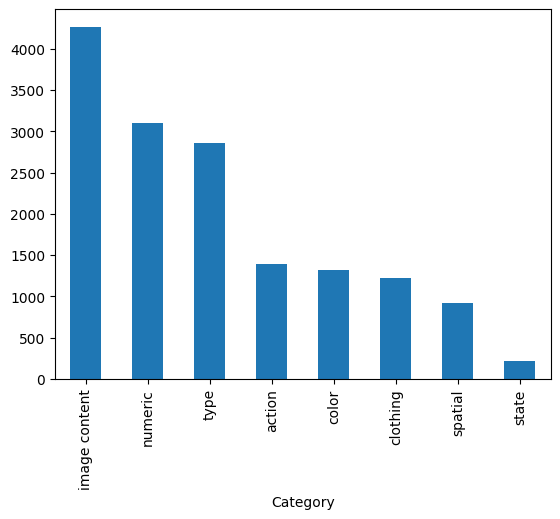

In [10]:
all_df.Category.value_counts().plot(kind='bar')
plt.show()

In [6]:
all_df.Question.str.len().describe()

count    15292.000000
mean        33.499542
std          8.995021
min         11.000000
25%         28.000000
50%         33.000000
75%         39.000000
max        105.000000
Name: Question, dtype: float64

In [5]:
all_df.Question.str.split().apply(len).describe()

count    15292.000000
mean         5.855872
std          1.464429
min          3.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         17.000000
Name: Question, dtype: float64

In [22]:
all_df.Answer_fixed.str.len().describe()

count    15292.000000
mean         7.100772
std          4.084018
min          1.000000
25%          4.000000
50%          6.000000
75%         10.000000
max         45.000000
Name: Answer_fixed, dtype: float64

In [147]:
all_df.Answer_fixed.str.split().apply(len).describe()

count    15292.000000
mean         1.431402
std          0.613062
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: Answer_fixed, dtype: float64

In [5]:
question_word_mapping = {
    "কী": "কি",
    "কে": "কে",
    "কখন": "কখন",
    "কবে": "কবে",
    "কোথায়": "কোথায়",
    "কোথায়": "কোথায়",
    "কোথা": "কোথায়",
    "কেন": "কেন",
    "কেমন": "কেমন",
    "কত": "কত",
    "কোন": "কোন",
    "কন": "কোন",
    "কিভাবে": "কিভাবে",
    "কি": "কি",
    "কয়": "কয়",
    "কয়": "কয়",
    "কজ": "কয়",
    "ক’জ": "কয়",
    "ক'জ": "কয়",
    "কটি": "কয়",
    "ক’টি": "কয়",
    "ক'টি": "কয়",
    "কার": "কার",
    "কাদের": "কাদের",
    "কটা": "কয়",
    "নাকি": "কি",
    "কাকে": "কে",
}

In [6]:
path = ['word1', 'word2', 'word3', 'word4']
question_words = ["কী", "কে", "কখন", "কবে", "কোথায়", "কোথায়", "কোথা", "কেন", "কেমন", "কত", "কোন", "কন", "কিভাবে", "কি", "কয়", "কয়", "কজ", "ক’জ", "ক'জ", "কটি", "ক’টি", "ক'টি", "কার", "কাদের", "কটা", "নাকি", "কাকে"]
wh_pattern = r'(\s+|^)(' + '|'.join(re.escape(word) for word in question_words) + r')\w*'
print(wh_pattern)

(\s+|^)(কী|কে|কখন|কবে|কোথায়|কোথায়|কোথা|কেন|কেমন|কত|কোন|কন|কিভাবে|কি|কয়|কয়|কজ|ক’জ|ক'জ|কটি|ক’টি|ক'টি|কার|কাদের|কটা|নাকি|কাকে)\w*


In [7]:
# Define a function to process the sentence intelligently
def process_question(sentence):
    sentence = sentence.rstrip('?')
    match = re.search(wh_pattern, sentence)
    
    if not match:
        print(sentence)
    
    question_word_pos = match.start()
    question_word_end_pos = match.end()
    before = sentence[:question_word_pos].strip().split()
    before_incl = sentence[:question_word_end_pos].strip().split()
    after = sentence[question_word_end_pos:].strip().split()
    after_incl = sentence[question_word_pos:].strip().split()

    # Choose the longer part or the part after if equal length
    if len(before) > len(after):
        selected_part = before_incl[-4:][::-1]  # Take the last 4 words and reverse
    else:
        selected_part = after_incl[:4]  # Take the first 4 words

    # Ensure the result has exactly 4 columns
    return selected_part + [None] * (4 - len(selected_part))

# Apply the function to the Pandas Series
processed_data = all_df.Question.apply(process_question)

# Create a DataFrame with up to 4 columns for the words
df = pd.DataFrame(processed_data.tolist(), columns=path)

# Print the DataFrame to check the structure
df

,word1,word2,word3,word4
0,কতগুলো,গাছের,প্রতিচ্ছবি,দেখা
1,কতজন,মানুষ,মঞ্চের,উপর
2,কতজন,ছেলে,ও,মেয়ে
3,কতজন,ছাত্র,ছাত্রী,রাস্তা
4,কতগুলো,গাছ,দেখা,যাচ্ছে
...,...,...,...,...
15287,কেমন,বিস্তার,বিল্ডিংগুলোর,দেখা
15288,কেমন,অবস্থা,আকাশের,None
15289,কেমন,অবস্থা,আকাশের,ছবিটিতে
15290,কেমন,আবহাওয়া,যাওয়া,দেখা


In [8]:
def map_prefix(word):
    for key in question_word_mapping:
        if word.startswith(key):
            return question_word_mapping[key]
    return word

# Apply the mapping function to the 'word1' column
df['word1'] = df['word1'].apply(map_prefix)
df

,word1,word2,word3,word4
0,কত,গাছের,প্রতিচ্ছবি,দেখা
1,কত,মানুষ,মঞ্চের,উপর
2,কত,ছেলে,ও,মেয়ে
3,কত,ছাত্র,ছাত্রী,রাস্তা
4,কত,গাছ,দেখা,যাচ্ছে
...,...,...,...,...
15287,কে,বিস্তার,বিল্ডিংগুলোর,দেখা
15288,কে,অবস্থা,আকাশের,None
15289,কে,অবস্থা,আকাশের,ছবিটিতে
15290,কে,আবহাওয়া,যাওয়া,দেখা


In [9]:
ambiguity_map = {
    "রঙ": "রং",
    "রঙের": "রং",
    "ধরন": "ধরণ",
    "ধরনের": "ধরণের",
    "দাঁড়িয়ে": "দাঁড়িয়ে"
}

def mapper(word):
    for key in ambiguity_map:
        if word == key:
            return ambiguity_map[key]
    return word

df['word2'] = df['word2'].apply(mapper)
df['word3'] = df['word3'].apply(mapper)
df['word4'] = df['word4'].apply(mapper)
df

,word1,word2,word3,word4
0,কত,গাছের,প্রতিচ্ছবি,দেখা
1,কত,মানুষ,মঞ্চের,উপর
2,কত,ছেলে,ও,মেয়ে
3,কত,ছাত্র,ছাত্রী,রাস্তা
4,কত,গাছ,দেখা,যাচ্ছে
...,...,...,...,...
15287,কে,বিস্তার,বিল্ডিংগুলোর,দেখা
15288,কে,অবস্থা,আকাশের,None
15289,কে,অবস্থা,আকাশের,ছবিটিতে
15290,কে,আবহাওয়া,যাওয়া,দেখা


In [10]:
df.word4.value_counts()[:10]

word4
দেখা       1494
ছবিতে      1215
যাচ্ছে      936
আছে         904
পরে         489
করছে        200
রয়েছে      183
আছেন        170
দাঁড়িয়ে     158
রয়েছে       156
Name: count, dtype: int64

In [12]:
df.word1.nunique()

11

In [13]:
df.word1.value_counts()

word1
কি        7314
কোন       3294
কত        2592
কোথায়     903
কয়        759
কে         317
কার         83
কখন         15
কিভাবে       9
কাদের        5
কবে          1
Name: count, dtype: int64

In [11]:
# Define a function to filter the top n values of a specified column grouped by another column
def filter_top(df, group_by_col, filter_col, n):
    # Group by the specified column and count occurrences
    top_n = df.groupby([group_by_col, filter_col]).size().groupby(level=0, group_keys=False).nlargest(n).reset_index()
    return df.merge(top_n[[group_by_col, filter_col]], on=[group_by_col, filter_col])

# Step 1: Filter top 5 word2 for each word1
df_filtered = filter_top(df, 'word1', 'word2', 5)

# Step 2: Filter top 5 word3 for the remaining word2
df_filtered = filter_top(df_filtered, 'word2', 'word3', 5)

# Step 3: Filter top 10 word4 for the remaining word3
df_filtered = filter_top(df_filtered, 'word3', 'word4', 3)
df_filtered

,word1,word2,word3,word4
0,কত,নৌকা,দেখা,যাচ্ছে
1,কত,পুরুষ,বসে,আছে
2,কয়,পুরুষ,দেখা,যাচ্ছে
3,কত,নৌকা,দেখা,যাচ্ছে
4,কত,লোক,দাঁড়িয়ে,আছে
...,...,...,...,...
1509,কে,অবস্থা,দোকানির,ছবিটিতে
1510,কে,অবস্থা,রাস্তার,ছবিতে
1511,কে,অবস্থা,আকাশের,ছবিতে
1512,কে,অবস্থা,আকাশের,ছবিটিতে


In [12]:
df_filtered.isna().sum()

word1    0
word2    0
word3    0
word4    0
dtype: int64

In [35]:
# df.fillna('NUL', inplace=True)
# df.dropna(ignore_index=True, inplace=True)
# df

In [13]:
def both_pad_dataframe(df, n):
    # Iterate over each column in the DataFrame
    df = df.copy()
    for col in df.columns:
        # Check if the column's dtype is object (commonly used for strings in pandas)
        if df[col].dtype == 'object':
            # Pad each string in the column individually
            df[col] = df[col].apply(lambda x: (' ' * (n // 2)) + str(x) + (' ' * (n // 2)))
    return df

padded_df = both_pad_dataframe(df_filtered, 10)
padded_df

,word1,word2,word3,word4
0,কত,নৌকা,দেখা,যাচ্ছে
1,কত,পুরুষ,বসে,আছে
2,কয়,পুরুষ,দেখা,যাচ্ছে
3,কত,নৌকা,দেখা,যাচ্ছে
4,কত,লোক,দাঁড়িয়ে,আছে
...,...,...,...,...
1509,কে,অবস্থা,দোকানির,ছবিটিতে
1510,কে,অবস্থা,রাস্তার,ছবিতে
1511,কে,অবস্থা,আকাশের,ছবিতে
1512,কে,অবস্থা,আকাশের,ছবিটিতে


In [21]:
wh_words = df_filtered['word1'].unique().tolist()
print(len(wh_words))
wh_words

palette = px.colors.qualitative.Prism
print(len(palette))

assert len(wh_words) < len(palette)

cmap = dict()
for color, wh_word in zip(palette[:len(wh_words)], wh_words):
    cmap[wh_word] = color
cmap

10
11


{'কত': 'rgb(95, 70, 144)',
 'কয়': 'rgb(29, 105, 150)',
 'কি': 'rgb(56, 166, 165)',
 'কে': 'rgb(15, 133, 84)',
 'কার': 'rgb(115, 175, 72)',
 'কখন': 'rgb(237, 173, 8)',
 'কিভাবে': 'rgb(225, 124, 5)',
 'কাদের': 'rgb(204, 80, 62)',
 'কোন': 'rgb(148, 52, 110)',
 'কোথায়': 'rgb(111, 64, 112)'}

In [22]:
ids = []
labels = []
parents = []
colors = []

for index, row in padded_df.iterrows():
    for i in range(1, 5):
        if row[f'word{i}'] is not None:
            if i == 1:
                parent = ""
            else:
                parent = ' '.join([row[f'word{j}'] for j in range(1, i) if row[f'word{j}'] is not None])
            label = row[f'word{i}']
            color = cmap[row['word1'].strip()]
            id = ' '.join([row[f'word{j}'] for j in range(1, i+1) if row[f'word{j}'] is not None])
            if id not in ids:
                ids.append(id)
                labels.append(label)
                parents.append(parent)
                colors.append(color)

In [23]:
fig = go.Figure(go.Sunburst(
    ids=ids,
    labels=labels,
    parents=parents,
#     marker=dict(colors=px.colors.qualitative.Pastel2),
    marker=dict(colors=colors),
    textinfo='label',
    insidetextorientation='radial'
))

# Customize the layout
fig.update_layout(
    font=dict(size=20),
    margin=dict(t=0, l=0, r=0, b=0),
    uniformtext=dict(minsize=20)
)

fig.show()

In [24]:
pio.write_image(fig, 'sunburst_chart_go.svg')

In [4]:
answers = all_df.Answer_en.str.lower()
answers

0               three
1                five
2                four
3                four
4                 two
             ...     
15287        gigantic
15288          cloudy
15289          cloudy
15290          cloudy
15291    floral dress
Name: Answer_en, Length: 15292, dtype: object

In [5]:
answers.sample(10).unique()

array(['white jersey', 'haystack', 'chinese noodles', 'drums', 'village',
       'water', 'goat', 'by boat', 'three', 'on wire'], dtype=object)

In [16]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased').to('cuda')

def get_embeddings(word_list):
    # Tokenize and get embeddings for a list of words
    inputs = tokenizer(word_list, return_tensors='pt', padding=True, truncation=True, max_length=128).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

In [35]:
categories = ['number', 'food', 'place', 'weather', 'animal', 'color', 'plant', 'material', 'activity', 'emotion', 'cloth', 'direction', 'human', 'vehicle', 'misc']
answers_list = answers.unique().tolist()
embeddings_answers = get_embeddings(answers_list)
embeddings_categories = get_embeddings(categories)

In [7]:
all_df[['Answer_fixed']].drop_duplicates().to_csv('answers.csv', index=False)

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings_answers.detach().cpu(), embeddings_categories.detach().cpu())

In [37]:
closest_indices = np.argmax(similarity_matrix, axis=1)
closest_words = [categories[index] for index in closest_indices]

In [39]:
for i, word in enumerate(answers_list[:100]):
    print(f"The closest word to '{word}' is '{closest_words[i]}'")

The closest word to 'three' is 'food'
The closest word to 'five' is 'cloth'
The closest word to 'four' is 'food'
The closest word to 'two' is 'direction'
The closest word to 'eight' is 'cloth'
The closest word to 'ten' is 'food'
The closest word to 'one' is 'direction'
The closest word to 'six' is 'food'
The closest word to 'three types' is 'cloth'
The closest word to 'two hands' is 'direction'
The closest word to 'seven' is 'cloth'
The closest word to 'seventeen' is 'cloth'
The closest word to 'nine' is 'cloth'
The closest word to 'multiple' is 'cloth'
The closest word to 'several' is 'cloth'
The closest word to 'many' is 'cloth'
The closest word to 'fifteen' is 'food'
The closest word to 'non' is 'human'
The closest word to 'busy' is 'food'
The closest word to 'fourths' is 'place'
The closest word to 'eleven' is 'cloth'
The closest word to 'seventy-seven' is 'food'
The closest word to 'six pieces' is 'cloth'
The closest word to 'five types' is 'color'
The closest word to 'many people

In [33]:
aa = pd.DataFrame(closest_words)
aa.value_counts()

0        
food         1010
cloth         748
activity      696
number        407
direction     336
animal        326
color         251
material      190
plant         113
weather        72
emotion        72
human          22
place           1
Name: count, dtype: int64

In [4]:
categories = {
    "Number": ['তিন', 'পাঁচ', 'চার', 'দুই', 'আট', 'দশ', 'এক', 'সাত', 'সতেরো', 'ছয়', 'পনেরো', 'নয়', 'এগারো', 'সাতাশ', 'তেরো', 'উনিশজন', 'বাইশ', 'ছয়', 'ষোল', 'একুশ', 'তিরিশ', 'ত্রিশ', 'দুজন', 'ছয়জন', 'অনেকগুলো'],
    "Food": ['বিরিয়ানি', 'পিঠা', 'মাংস', 'ফুচকা', 'আইসক্রিম', 'কলা', 'পান', 'মালাই'],
    "Place": ['শহর', 'নদী', 'পাহাড়', 'বাজার', 'গ্রাম', 'ফ্লাইওভার', 'লেক', 'ঝর্না', 'বাংলাদেশ', 'পুকুর'],
    "Weather": ['বৃষ্টি', 'কুয়াশা', 'ঝড়', 'রোদ', 'শীত', 'কালো মেঘে', 'মেঘলা', 'মেঘাচ্ছন্ন'],
    "Animal": ['বিড়াল', 'কুকুর', 'হাতি', 'বাঘ', 'গরু', 'মুরগী', 'মহিষ', 'কাক'],
    "Color": ['লাল', 'নীল', 'সবুজ', 'হলুদ', 'সাদা', 'কালো', 'গোলাপি', 'কমলা', 'বেগুনি', 'বাদামি'],
    "Plant": ['গাছ', 'ফুল', 'বাঁশ', 'নিম', 'কাঁঠাল', 'ধান ক্ষেত', 'ধান', 'গোলাপ', 'সরিষা'],
    "Material": ['কাঠ', 'লোহা', 'স্টিল', 'কাচ', 'টিন'],
    "Activity": ['খেলা', 'দৌড়', 'পড়া', 'গান', 'নাচ', 'কাজ', 'লাফ দিচ্ছে', 'বসে আছে', 'হাসছে', 'হাঁটছে', 'দাঁড়িয়ে আছে', 'দাঁড়িয়ে আছে'],
    "Emotion": ['হাসি', 'কান্না', 'রাগ', 'সুখ', 'দুঃখ', 'বিরক্তি', 'ভালোবাসা'],
    "Cloth": ['জামা', 'প্যান্ট', 'টুপি', 'শাড়ি', 'গামছা', 'কাপড়', 'রুমাল', 'শাড়ি', 'লুঙ্গি', 'পাঞ্জাবি', 'শারি', 'গেঞ্জি'],
    "Direction": ['উত্তর', 'দক্ষিণ', 'পূর্ব', 'পশ্চিম', 'সামনে', 'পেছনে', 'ডান', 'বাম'],
    "Human": ['পুরুষ', 'নারী', 'শিশু', 'বন্ধু', 'শিক্ষক', 'বাবা', 'মা'],
    "Vehicle": ['গাড়ি', 'বাস', 'ট্রেন', 'নৌকা', 'বিমান', 'রিক্সা', 'রিকশা'],
    "Time": ['সন্ধ্যা', 'সূর্যাস্তের সময়', 'সূর্যাস্ত'],
    "Object": ['ছাতা', 'বই', 'ক্যামেরা', 'লাঠি', 'জাল', 'বৈঠা']
}


In [5]:
def categorize_word(word):
    for category, words in categories.items():
        for cword in words:
            if cword in word:
                return category
    return "Other"

# Apply the categorization function to the dataframe
all_df['Category'] = all_df['Answer_fixed'].apply(categorize_word)
all_df

,image_name,Captions,Question,Answer,Category,Question_en,Answer_en,Captions_en,Answer_fixed
0,bnature_663.jpg,খালের পানিতে তিনটি গাছের প্রতিচ্ছবি সাথে গৌধোল...,ছবিতে কতগুলো গাছের প্রতিচ্ছবি দেখা যাচ্ছে?,তিনটি,Number,How many trees are reflected in the picture?,three,Goudholi's beauty with three trees reflected i...,তিন
1,chitron_5113.png,অনেকগুলো মানুষ বসে আছে। মঞ্চের উপর কয়েকজন মানু...,ছবিতে কতজন মানুষ মঞ্চের উপর দাঁড়িয়ে আছে?,পাঁচজন,Number,How many people are on the stage?,five,"A lot of people were sitting, a few people wer...",পাঁচ
2,bnature_876.jpg,দুজন ছেলে ও দুজন মেয়ে রাস্তা দিয়ে পাশাপাশি হ...,ছবিতে কতজন ছেলে ও মেয়ে একসাথে হাটছে?,চারজন,Number,How many boys and girls are walking together i...,four,Two boys and two girls walking side by side on...,চার
3,bnature_1007.jpg,"রাস্তা দিয়ে কয়েকজন ছাত্র ছাত্রী যাচ্ছে, যাদে...",ছবিতে কতজন ছাত্র ছাত্রী রাস্তা দিয়ে হাঁটছে?,৪ জন,Number,How many students are walking on the street in...,four,"Several students walking on the street, carryi...",চার
4,chitron_7446.png,'১ ইট তালগাছ ১ টি খেজুর গাছ এবং রাস্তা দিয়ে ছা...,ছবিতে কতগুলো গাছ দেখা যাচ্ছে?,২ টি,Number,How many trees are shown in the picture?,Two,1 brick palm tree 1 date tree and 4 school stu...,দুই
...,...,...,...,...,...,...,...,...,...
15287,bnature_1183.jpg,একটি শহরের ছোট বড় উঁচু নিচু অনেক গুলো বিল্ডিং...,এই ছবিতে দেখা বিল্ডিংগুলোর বিস্তার কেমন?,বিশাল,Other,What is the extent of the buildings seen in th...,gigantic,"A city with many buildings, big and small, hug...",বিশাল
15288,bornon_465.jpg,উচু জায়গা থেকে তোলা সবুজ জঙ্গলের ছবি দেখা যাচ...,আকাশের অবস্থা কেমন ছবিতে?,মেঘলা,Weather,How's the sky?,cloudy,"A green jungle, a white cloud above, a cloudy ...",মেঘলা
15289,bornon_3591.jpg,একটি শহরের বিভিন্ন রঙের দালান ও কালো মেঘযুক্ত ...,এই ছবিটিতে আকাশের অবস্থা কেমন চিত্রিত হয়েছে?,মেঘযুক্ত,Other,How is the sky depicted in this picture?,cloudy,A city with different colors of buildings and ...,মেঘযুক্ত
15290,bornon_1638.jpg,"দিগন্ত-জোড়া গাছপালা দেখা যাচ্ছে ।,\n আকাশ দেখ...",ছবিতে দেখা যাওয়া আবহাওয়া কেমন?,মেঘলা,Weather,What is the weather in the picture?,cloudy,"The horizon is full of trees, the sky is full ...",মেঘলা


In [6]:
all_df.Category.value_counts()

Category
Other        5687
Number       3333
Color        1906
Plant         777
Cloth         598
Human         552
Place         466
Food          330
Activity      317
Vehicle       309
Object        259
Time          212
Weather       167
Material      140
Animal        107
Direction     104
Emotion        28
Name: count, dtype: int64

In [9]:
all_df[all_df.Category == 'Other']['Answer_fixed'].value_counts()

Answer_fixed
হ্যাঁ                58
ক্রিকেট              19
স্কুল ড্রেস          17
চা                   16
ছাদে                 16
                     ..
শিক্ষা প্রতিষ্ঠান     1
জঙ্গল ও মেঘ           1
পাহাড় দেখছেন          1
চকলেট ও ভ্যানিলা      1
উলটে                  1
Name: count, Length: 3265, dtype: int64

In [10]:
# all_df.to_csv('categorized.csv', index=False)

In [11]:
category_counts_df = all_df.Category.value_counts().reset_index()
category_counts_df.columns = ['Category', 'Count']
category_counts_df

,Category,Count
0,Other,5687
1,Number,3333
2,Color,1906
3,Plant,777
4,Cloth,598
5,Human,552
6,Place,466
7,Food,330
8,Activity,317
9,Vehicle,309


In [12]:
import plotly.graph_objects as go

labels = category_counts_df.Category
values = category_counts_df.Count

colors = px.colors.qualitative.Prism

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, 
    hole=.5, 
    marker=dict(colors=colors)
)])

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    legend=dict(
        orientation="v",
        x=0.9,  # Position legend to the right of the pie chart
        y=0.5,
        xanchor="left",
        yanchor="middle"
    )
)
fig.show()

In [13]:
pio.write_image(fig, 'donut_chart.svg')

In [23]:
wh_counts_df = df.word1.value_counts().reset_index()
wh_counts_df.columns = ['WH', 'Count']
wh_counts_df['PC'] = (wh_counts_df['Count'] / len(df)) * 100
wh_counts_df

,WH,Count,PC
0,কি,7314,47.828930
1,কোন,3294,21.540675
2,কত,2592,16.950039
3,কোথায়,903,5.905048
4,কয়,759,4.963380
5,কে,317,2.072979
6,কার,83,0.542767
7,কখন,15,0.098091
8,কিভাবে,9,0.058854
9,কাদের,5,0.032697
